# Imports

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
plt.style.use('fivethirtyeight')

# Model Class

In [33]:
class SimpleTrainingProcess(object):
    def __init__(self, model, loss_fn, optimizer):
        # model and training
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = self._detect_device()
        print(f"Device: {self.device}")
        self.model.to(self.device)

        # data
        self.train_loader = None
        self.validation_loader = None
        self.writer = None

        # metrics
        self.losses = []
        self.validation_losses = []
        self.total_epochs = 0

        # functions
        self.train_step_fn = self._make_train_step_fn()
        self.validation_step_fn = self._make_validation_step_fn()

    def to(self, device):
        try:
            self.device = device
            self.model.to(device)
        except RuntimeError:
            self.device = self._detect_device()
            print(f"Device {device} not available. Using {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, validation_loader=None):
        self.train_loader = train_loader
        self.validation_loader = validation_loader

    def set_tensorboard(self, name, folder="runs"):
        self.writer = SummaryWriter(log_dir=f"{folder}/{name}")

    def _detect_device(self):
        if torch.cuda.is_available():
            return torch.device("cuda")
        elif torch.backends.mps.is_available():
            return torch.device("mps")
        else:
            return torch.device("cpu")

    # Higher order function for training
    def _make_train_step_fn(self):
        def train_step_fn(x, y):
            # set model to train mode
            self.model.train()

            # forward pass
            yhat = self.model(x)

            # compute loss
            loss = self.loss_fn(yhat, y)

            # compute gradients
            loss.backward()

            # update parameters
            self.optimizer.step()
            self.optimizer.zero_grad()

            return loss.item()

        return train_step_fn

    # Higher order function for validation
    def _make_validation_step_fn(self):
        def validation_step_fn(x, y):
            # set model to eval mode
            self.model.eval()

            # forward pass
            yhat = self.model(x)

            # compute loss
            loss = self.loss_fn(yhat, y)

            return loss.item()

        return validation_step_fn

    def _mini_batch(self, validation=False):
        if validation:
            data_loader = self.validation_loader
            step_fn = self.validation_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        # mini-batch loop
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        self.set_seed(seed)
        for epoch in range(n_epochs):
            self.total_epochs += 1

            # inner loop
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # validation
            with torch.no_grad():
                # perform evaluation
                validation_loss = self._mini_batch(validation=True)
                self.validation_losses.append(validation_loss)

            # SummaryWriter for Tensorboard
            if self.writer:
                scalars = {"training": loss}
                if validation_loss is not None:
                    scalars.update({"validation": validation_loss})
                # record both losses under tag "loss"
                self.writer.add_scalars(
                    main_tag="loss", tag_scalar_dict=scalars, global_step=epoch
                )

        # write events to disk
        if self.writer:
            self.writer.flush()

    def save_checkpoint(self, filename):
        # builds state dictionary
        checkpoint = {
            "epoch": self.total_epochs,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "loss": self.losses,
            "validation_loss": self.validation_losses,
        }
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # loads state dictionary
        checkpoint = torch.load(filename)

        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.total_epochs = checkpoint["epoch"]
        self.losses = checkpoint["loss"]
        self.validation_losses = checkpoint["validation_loss"]
        # resume training
        self.model.train()

    def predict(self, x):
        # set model to eval mode
        self.model.eval()

        # numpy to tensor
        x_tensor = torch.as_tensor(x).float()

        # forward pass
        y_hat_tensor = self.model(x_tensor.to(self.device))

        # back to train mode
        self.model.train()

        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label="Training Loss", c="b")
        if self.validation_losses:
            plt.plot(self.validation_losses, label="Validation Loss", c="r")
        plt.yscale("log")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Train Process")
        plt.tight_layout()

    def add_graph(self):
        if self.train_loader and self.writer:
            x_dummy, _ = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))

# Data Generation

In [34]:
# Syntetic Data Generation
true_b = 1
true_w = 2
N = 200

x = np.random.rand(N, 1)
epsilon = 0.1 * np.random.randn(N, 1)
y = true_b + true_w * x + epsilon

x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()
# All data points
dataset = TensorDataset(x_tensor, y_tensor)

# Generates train and validation sets
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_validation = n_total - n_train
train_data, validation_data = random_split(dataset, [n_train, n_validation])
display(train_data[:5])

# Data Loaders
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=16)

(tensor([[0.0903],
         [0.0344],
         [0.4402],
         [0.1560],
         [0.2809]]),
 tensor([[1.2488],
         [1.0861],
         [1.9659],
         [1.3594],
         [1.4846]]))

Device: mps


OrderedDict([('0.weight', tensor([[1.9869]], device='mps:0')),
             ('0.bias', tensor([1.0133], device='mps:0'))])

200

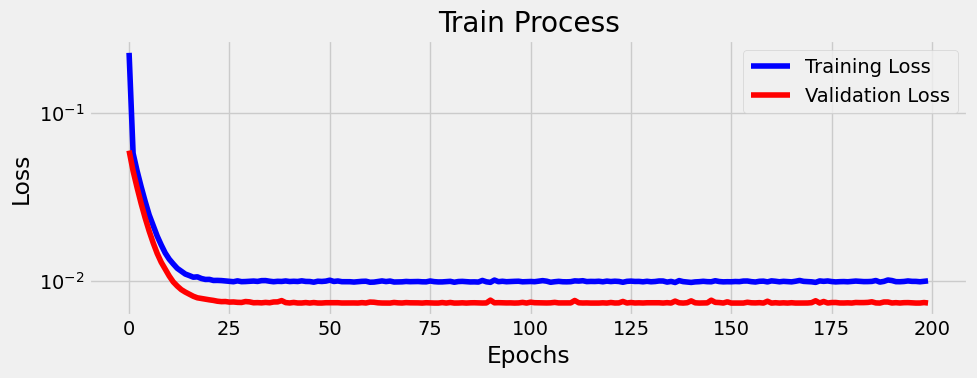

In [35]:
lr = 0.1

torch.manual_seed(42)

# linear regression model
model = nn.Sequential(nn.Linear(1, 1))
# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)
# MSE Loss Fn
loss_fn = nn.MSELoss(reduction="mean")

stp = SimpleTrainingProcess(model, loss_fn, optimizer)
stp.set_loaders(train_loader, validation_loader)
stp.set_tensorboard("ch2_1")
stp.train(n_epochs=200)
display(model.state_dict())
display(stp.total_epochs)

stp.plot_losses()
plt.show()

# Making Predictions

In [37]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [38]:
predictions = stp.predict(new_data)
predictions

array([[2.0067534],
       [1.6093805],
       [2.4041266]], dtype=float32)